#Import Library

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import toolz as tz
import os 
# from google.colab import drive
# drive.mount('/content/drive')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as py
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


#Data Exploration and preprocessing

In [110]:
Ny_Home_Df = pd.read_csv('Sensors.csv')
Ny_Home_Df = Ny_Home_Df[0:-1] # Last row seems invalid

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.



In [51]:
Ny_Home_Df.head(10)

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
5,1451624405,1.391867,0.003433,1.391867,0.000283,0.503250,0.063667,0.447033,0.122300,0.006717,0.012433,0.000483,0.000567,0.000000,0.031450,0.001017,0.004067,0.001583,0.003433,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
6,1451624406,1.366217,0.003450,1.366217,0.000283,0.499400,0.063717,0.443267,0.122050,0.006733,0.012417,0.000517,0.000550,0.000000,0.031550,0.001033,0.004117,0.001533,0.003450,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
7,1451624407,1.431900,0.003417,1.431900,0.000250,0.477867,0.178633,0.444283,0.121800,0.006783,0.012550,0.000483,0.000450,0.000000,0.031733,0.001033,0.004200,0.001550,0.003417,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
8,1451624408,1.627300,0.003417,1.627300,0.000183,0.447650,0.365700,0.441467,0.121617,0.006950,0.012717,0.000467,0.000300,0.000017,0.031767,0.001017,0.004200,0.001567,0.003417,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
9,1451624409,1.735383,0.003417,1.735383,0.000017,0.171550,0.682500,0.438733,0.121633,0.007233,0.013350,0.000367,0.000050,0.000000,0.031667,0.001017,0.004200,0.001617,0.003417,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


##Data Cleaning

In [111]:
Ny_Home_Df.columns = [col.replace(' [kW]', '') for col in Ny_Home_Df.columns]
Ny_Home_Df.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [112]:
Ny_Home_Df['All_Furnace'] = Ny_Home_Df[['Furnace 1','Furnace 2']].sum(axis=1)
Ny_Home_Df['All_Kitchen'] = Ny_Home_Df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)

In [113]:
import time 
print(Ny_Home_Df['time'].iloc[0])
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(Ny_Home_Df['time'].iloc[0]))))

1451624400
 start  2016-01-01 05:00:00


In [114]:
time_index = pd.date_range('2016-01-01 05:00', periods=len(Ny_Home_Df),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
Ny_Home_Df = Ny_Home_Df.set_index(time_index)
Ny_Home_Df = Ny_Home_Df.drop(['time'], axis=1)
Ny_Home_Df.iloc[np.r_[0:5,-5:0]].iloc[:,0]

2016-01-01 05:00:00    0.932833
2016-01-01 05:01:00    0.934333
2016-01-01 05:02:00    0.931817
2016-01-01 05:03:00    1.022050
2016-01-01 05:04:00    1.139400
2016-12-16 03:25:00    1.601233
2016-12-16 03:26:00    1.599333
2016-12-16 03:27:00    1.924267
2016-12-16 03:28:00    1.978200
2016-12-16 03:29:00    1.990950
Name: use, dtype: float64

In [115]:
Ny_Home_Df.columns
Ny_Home_Df = Ny_Home_Df.drop(columns=['House overall'])
Ny_Home_Df = Ny_Home_Df.drop(columns=['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38'])
Ny_Home_Df = Ny_Home_Df.drop(columns=['icon','summary'])

In [118]:
Ny_Home_Df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
Ny_Home_Df['cloudCover'] = Ny_Home_Df['cloudCover'].astype('float')
Ny_Home_Df['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

In [137]:
Ny_Home_Df.head()

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,All_Furnace,All_Kitchen
2016-01-01 05:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.082617,0.000567
2016-01-01 05:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.084533,0.000567
2016-01-01 05:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.083017,0.000617
2016-01-01 05:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.175417,0.000650
2016-01-01 05:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.300917,0.000783


##Resample the dataset into daily base

In [124]:
df = Ny_Home_Df.copy()

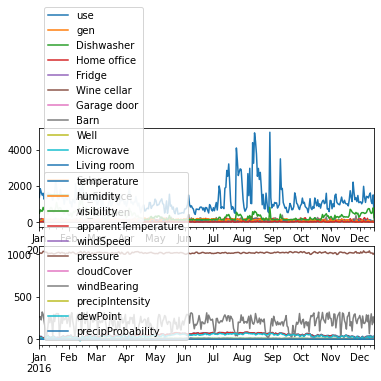

In [125]:
features = ['temperature','humidity', 'visibility','apparentTemperature','windSpeed', 'pressure', 'cloudCover', 'windBearing', 'precipIntensity','dewPoint','precipProbability']
targets = ['use','gen','Dishwasher','Home office','Fridge','Wine cellar','Garage door','Barn','Well','Microwave','Living room','Solar', 'All_Furnace' ,'All_Kitchen']
fig, axes = plt.subplots(nrows=2, ncols=1)
df[targets].resample('D').sum().plot(ax=axes[0])
df[features].resample('D').mean().plot(ax=axes[1])

In [127]:
df = df[targets].resample('D').sum()

In [132]:
df1 = Ny_Home_Df[features].resample('D').mean()

In [144]:
df_day = pd.concat([df, df1], axis=1)
df_day.head()

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,All_Furnace,All_Kitchen,temperature,humidity,visibility,apparentTemperature,windSpeed,pressure,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
2016-01-01,1366.269517,18.026200,59.517171,64.668783,94.740300,29.093367,15.228367,99.622950,30.537233,12.961117,77.071667,18.026200,492.020017,11.619833,35.725737,0.631825,9.759298,29.815211,7.386772,1014.740316,0.669456,263.689474,0.000112,24.429175,0.002035
2016-01-02,1851.521067,76.051300,63.154404,145.570317,74.851733,24.096767,19.246333,185.776967,33.688133,12.480300,71.142950,76.051300,683.761967,15.464256,31.692569,0.580056,9.953722,24.462806,8.148319,1014.510944,0.235000,264.529167,0.000000,18.498597,0.000000
2016-01-03,1651.128133,74.081433,105.508668,196.064167,92.149033,32.989533,19.444933,146.493667,31.955233,19.066117,42.779250,74.081433,613.630533,19.092004,33.273625,0.613597,10.000000,26.769736,7.616264,1009.626375,0.185472,227.120833,0.000000,21.252958,0.000000
2016-01-04,1500.686017,108.525017,58.880760,180.650867,71.016683,20.980700,19.249983,47.837017,43.438883,20.249933,93.077467,108.525017,605.129767,17.346254,22.297722,0.598597,9.805056,11.067278,11.226181,1016.432236,0.151875,319.797222,0.000000,10.302708,0.000000
2016-01-05,1597.968867,148.107500,72.973254,133.360867,80.135633,30.792300,19.773067,50.166067,19.157417,16.658967,44.483650,148.107500,817.065250,14.754489,11.950139,0.535292,9.996375,2.759708,6.661236,1034.091292,0.010944,291.412500,0.000000,-2.286222,0.000000


In [145]:
df_day.shape

(351, 25)

##Add Time (Month&Day) and Time-Lag as New Features

In [146]:
df_features = (
                df_day
                .assign(day = df_day.index.day)
                .assign(month = df_day.index.month)
                .assign(day_of_week = df_day.index.dayofweek)
              )

In [325]:
df_features.head()

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,All_Furnace,All_Kitchen,temperature,humidity,visibility,apparentTemperature,windSpeed,pressure,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,day,month,day_of_week
2016-01-01,1366.269517,18.026200,59.517171,64.668783,94.740300,29.093367,15.228367,99.622950,30.537233,12.961117,77.071667,18.026200,492.020017,11.619833,35.725737,0.631825,9.759298,29.815211,7.386772,1014.740316,0.669456,263.689474,0.000112,24.429175,0.002035,1,1,4
2016-01-02,1851.521067,76.051300,63.154404,145.570317,74.851733,24.096767,19.246333,185.776967,33.688133,12.480300,71.142950,76.051300,683.761967,15.464256,31.692569,0.580056,9.953722,24.462806,8.148319,1014.510944,0.235000,264.529167,0.000000,18.498597,0.000000,2,1,5
2016-01-03,1651.128133,74.081433,105.508668,196.064167,92.149033,32.989533,19.444933,146.493667,31.955233,19.066117,42.779250,74.081433,613.630533,19.092004,33.273625,0.613597,10.000000,26.769736,7.616264,1009.626375,0.185472,227.120833,0.000000,21.252958,0.000000,3,1,6
2016-01-04,1500.686017,108.525017,58.880760,180.650867,71.016683,20.980700,19.249983,47.837017,43.438883,20.249933,93.077467,108.525017,605.129767,17.346254,22.297722,0.598597,9.805056,11.067278,11.226181,1016.432236,0.151875,319.797222,0.000000,10.302708,0.000000,4,1,0
2016-01-05,1597.968867,148.107500,72.973254,133.360867,80.135633,30.792300,19.773067,50.166067,19.157417,16.658967,44.483650,148.107500,817.065250,14.754489,11.950139,0.535292,9.996375,2.759708,6.661236,1034.091292,0.010944,291.412500,0.000000,-2.286222,0.000000,5,1,1


In [157]:
def generate_time_lags1(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"Dish_pre{n}"] = df_n["Dishwasher"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
def generate_time_lags2(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"Fridge_pre{n}"] = df_n["Fridge"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 2
df_timelags = generate_time_lags1(df_features, input_dim)
df_timelags = generate_time_lags2(df_timelags, input_dim)
df_timelags

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,All_Furnace,All_Kitchen,temperature,humidity,visibility,apparentTemperature,windSpeed,pressure,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,day,month,day_of_week,Dish_pre1,Dish_pre2,Fridge_pre1,Fridge_pre2
2016-01-05,1597.968867,148.107500,72.973254,133.360867,80.135633,30.792300,19.773067,50.166067,19.157417,16.658967,44.483650,148.107500,817.065250,14.754489,11.950139,0.535292,9.996375,2.759708,6.661236,1034.091292,0.010944,291.412500,0.000000,-2.286222,0.000000,5,1,1,58.880760,105.508668,71.016683,92.149033
2016-01-06,1267.262700,136.922033,0.140792,167.216517,61.036117,19.105800,20.218567,45.199050,15.802967,6.025933,47.648100,136.922033,685.990133,7.764805,19.975833,0.572986,9.951667,15.780972,3.977069,1032.543806,0.010472,217.036111,0.000000,5.545167,0.000000,6,1,2,72.973254,58.880760,80.135633,71.016683
2016-01-07,1388.444150,111.077217,68.746322,146.354700,67.342050,29.777033,18.623717,167.897800,16.100967,31.148183,75.690783,111.077217,568.106683,15.623387,23.332667,0.622042,9.921667,21.712097,2.483875,1026.294819,0.010875,137.990278,0.000000,11.057875,0.000000,7,1,3,0.140792,72.973254,61.036117,80.135633
2016-01-08,1584.852233,31.267217,62.607221,159.989967,153.470417,25.382883,21.282750,144.663933,17.811250,10.473550,69.618500,31.267217,630.874083,15.046586,29.488389,0.717472,9.865264,24.486931,4.918819,1024.378375,0.179972,36.411111,0.000000,21.335722,0.000000,8,1,4,68.746322,0.140792,67.342050,61.036117
2016-01-09,1303.707900,27.691133,0.094325,113.336783,64.852450,26.653533,21.481850,145.845417,21.057633,10.352750,55.883617,27.691133,553.466300,14.421155,37.799556,0.797667,8.960806,34.730708,4.209681,1022.690694,0.445778,63.490278,0.000000,32.069556,0.000000,9,1,5,62.607221,68.746322,153.470417,67.342050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-12,1617.835017,8.129833,0.108675,59.676483,64.955017,40.523333,22.473050,47.439633,16.910450,7.203117,124.287683,8.129833,567.282667,10.675023,43.898000,0.792965,8.139528,39.860250,9.628493,1015.268514,0.622403,213.577083,0.001077,37.586049,0.035625,12,12,0,0.149122,70.463005,68.930700,86.827283
2016-12-13,1133.408117,41.989967,70.469589,59.511567,82.265933,30.369767,19.151850,48.607150,16.781650,4.553933,85.476550,41.989967,480.261467,10.267541,35.555826,0.617097,9.892333,28.305771,9.807250,1014.644944,0.298854,298.526389,0.000000,23.695014,0.000000,13,12,1,0.108675,0.149122,64.955017,68.930700
2016-12-14,1026.850250,52.339200,0.095493,59.465533,75.854333,39.065917,21.250750,48.728567,8.872367,6.204917,52.031633,52.339200,519.290850,5.734158,29.963292,0.782819,7.431125,26.725819,4.039736,1013.819625,0.382917,171.723611,0.009142,23.834139,0.187951,14,12,2,70.469589,0.108675,82.265933,64.955017
2016-12-15,1508.666433,59.329550,73.094186,60.550000,62.367067,25.967883,18.775450,45.537250,18.833650,41.695250,79.758350,59.329550,791.562067,5.957887,32.682153,0.753951,8.815250,25.109743,10.321722,999.368792,0.170583,264.139583,0.001153,25.579729,0.046319,15,12,3,0.095493,70.469589,75.854333,82.265933


##Standardize Data and Create Data Loader

In [326]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[target_col]
    X = df.drop(columns=target_col)
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

target_col = ['use','gen','Dishwasher','Home office','Fridge','Wine cellar','Garage door','Barn','Well','Microwave','Living room','Solar', 'All_Furnace' ,'All_Kitchen']
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features, target_col, 0.2)

In [327]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

scaler = get_scaler('standard')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [328]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16
train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

#Training

In [169]:
import torch
import torch.nn as nn
from datetime import datetime
def get_model(model, model_params):
    models = {
        "lstm": LSTMModel
    }
    return models.get(model.lower())(**model_params)

##Models

In [191]:
class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           lstm (nn.LSTM): The LSTM model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state
                           of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a LSTM instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        # h0 = h0.to(self.device)
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        # c0 = c0.to(self.device)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

##Train

In [200]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().cpu().clone().numpy())
                values.append(y_test.to(device).detach().cpu().clone().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

##Test

[1/1000] Training loss: 1.0238	 Validation loss: 2.4146
[2/1000] Training loss: 1.0180	 Validation loss: 2.4167
[3/1000] Training loss: 1.0135	 Validation loss: 2.4180
[4/1000] Training loss: 1.0102	 Validation loss: 2.4191
[5/1000] Training loss: 1.0061	 Validation loss: 2.4200
[6/1000] Training loss: 1.0026	 Validation loss: 2.4203
[7/1000] Training loss: 0.9983	 Validation loss: 2.4199
[8/1000] Training loss: 0.9939	 Validation loss: 2.4189
[9/1000] Training loss: 0.9888	 Validation loss: 2.4167
[10/1000] Training loss: 0.9821	 Validation loss: 2.4134
[50/1000] Training loss: 0.8252	 Validation loss: 2.2858
[100/1000] Training loss: 0.7702	 Validation loss: 2.2551
[150/1000] Training loss: 0.7323	 Validation loss: 2.2063
[200/1000] Training loss: 0.6739	 Validation loss: 2.1299
[250/1000] Training loss: 0.6656	 Validation loss: 2.0775
[300/1000] Training loss: 0.6503	 Validation loss: 2.0556
[350/1000] Training loss: 0.6238	 Validation loss: 2.0509
[400/1000] Training loss: 0.6163	 

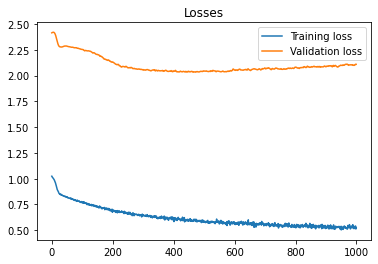

In [341]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 12
layer_dim = 2
batch_size = 16
dropout = 0.2
n_epochs = 1000
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout,
                }

model = get_model('lstm', model_params)
model = model.to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

##Prediction Result

The following code can be use for dashboard

In [ ]:
# def inverse_transform(scaler, df, columns):
#     for col in columns:
#         df[col] = scaler.inverse_transform(df[col])
#     return df

# def format_predictions(predictions, values, df_test, scaler, target_col):
#     pred = np.array(predictions)
#     preds = pred.reshape((pred.shape[0],-1))
#     val = np.array(values)
#     vals = val.reshape((val.shape[0],-1))
#     df_pred = pd.DataFrame(preds,columns=target_col,index=X_test.head(len(vals)).index)
#     df_val = pd.DataFrame(vals,columns=target_col,index=X_test.head(len(vals)).index)
#     df_pred = df_pred.sort_index()
#     df_val = df_val.sort_index()
#     df_pred = inverse_transform(scaler, df_pred, [target_col])
#     df_val = inverse_transform(scaler, df_val, [target_col])
#     return df_pred, df_val

# df_pred, df_val = format_predictions(predictions, values, X_test, scaler, target_col)
# df_pred

In [342]:
pred = np.array(predictions)
preds = pred.reshape((pred.shape[0],-1))
val = np.array(values)
vals = val.reshape((val.shape[0],-1))
data_predict = scaler.inverse_transform(preds)
dataY_plot = scaler.inverse_transform(vals)

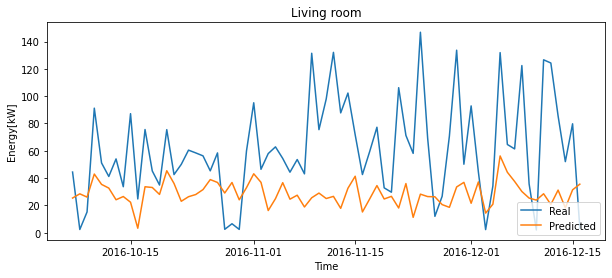

In [353]:
feature = 10
f = plt.figure(figsize=(10,4))
plt.plot(X_test.head(len(vals)).index,dataY_plot[:,feature])
plt.plot(X_test.head(len(vals)).index,data_predict[:,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()